# ヒューマノイドロボット入門Part2
## ヒューマノイドロボットの運動学
### モデルの作成法
以下の12自由度の2足歩行ロボットについて考える。関節の名称とID番号は図のように設定する。
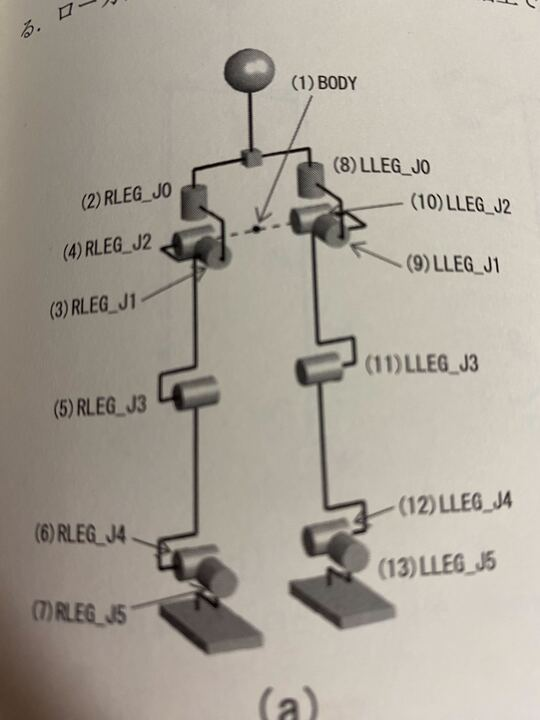

まず各リンクの位置と姿勢を表すためのローカル座標系を設定する必要がある。ローカル座標系の原点は関節の回転軸上であればどこに設定してもよい。
ただし、このロボットの股関節は3軸が1点で交わっているので3つのリンクの原点をすべて股関節の中心に設定するのが合理的である。同様に足首についても2軸の交点を原点に設定する。

また、ローカル座標系の回転行列については基準姿勢において、すべてワールド座標系と平行する。すなわち、\
$$
R_1 = R_2 = ... = R_{13} = E
$$\
設定したローカル座標系は下図のようになる。\
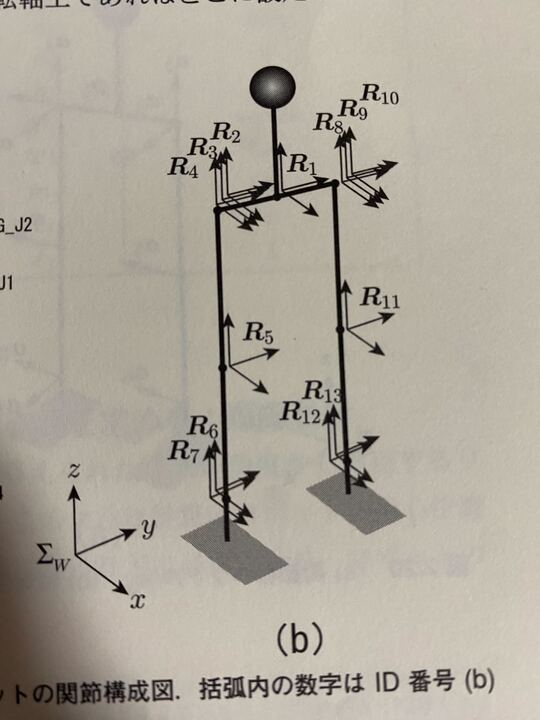

次に隣り合うローカル座標系の間の関係を表現する。
関節軸ベクトル**a**は、親リンクに対する自リンクの回転軸を表すベクトルで、矢印に沿った右ねじの回転方向を正とする。\
例えば、膝関節の関節軸ベクトルは\
$$
    a_5. a_{11} = [0\quad1\quad0]^T
$$
であり、正方向に回転すると膝が通常方向に曲がるように設定されている。\
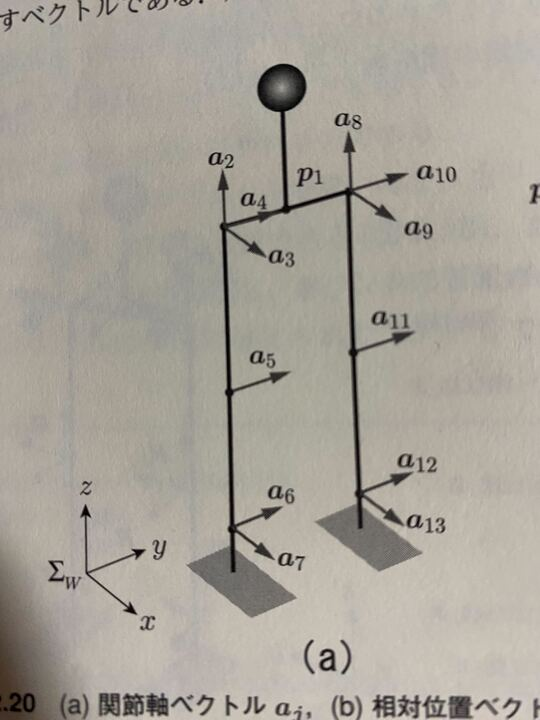

また相対位置ベクトル**b**は、親リンク原点から自リンク原点を指すベクトルである。足首ロール軸のように親リンクと原点を享有する場合には\
$$
b_7, b_{13} = 0
$$
となる。\
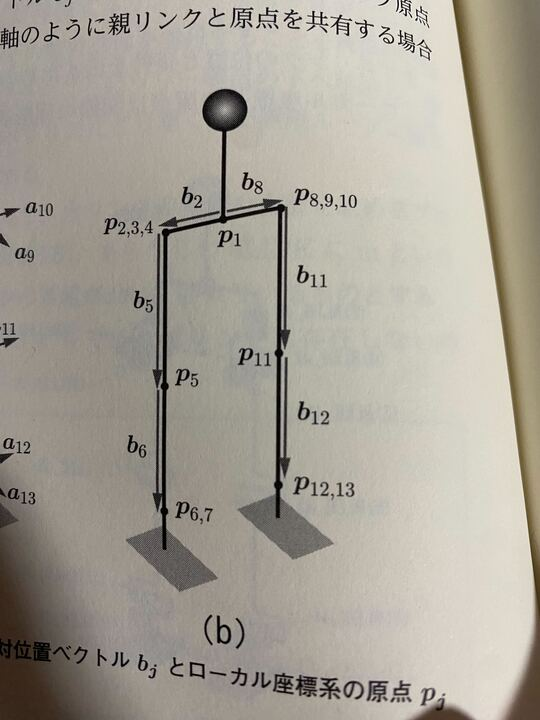

## 関節角度からリンク位置と姿勢を求める：順運動学
**順運動学**とは与えられた関節の角度から注目するリンクの位置と姿勢を求めることをいう。\
このような計算はロボットの重心位置の計算、グラフィック表示、環境との接触判定などに必要になり、ロボットのシミュレーションの根幹をなす。\
順運動学の計算は同次変換行列(1)とチェーンルール(2)によって簡単に行える。\
まず以下のような1個のリンクの同次変換行列を求める。関節回転軸上に原点を持つローカル座標系$Σ_j$を設定する。親リンク座標系で見た回転軸ベクトルが$a_j$、$Σ_j$の原点が$b_j$である。関節の回転角を$q_j$、回転角0の初期状態におけるリンクの姿勢行列を**E**とする。\
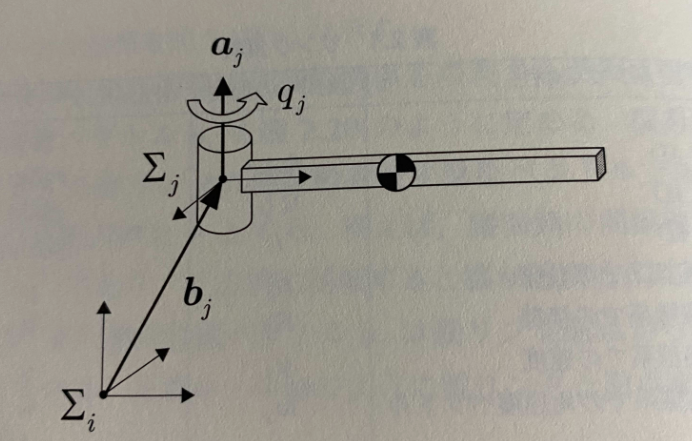

$Σ_j$の親リンク相対の同次変換行列は\
$$
^iT_j = 
\begin{bmatrix}
e^{\hat{a_j}q_j} & b_j\\
000 & 1\\
\end{bmatrix}
$$

ここで、ウェッジ(^)は3次元ベクトルからひずみ対称行列を作る操作である。詳しくはこのファイルの最後で説明する。(3)

次に下図のように連続した二つのリンクi, jがあり、親リンクの絶対位置・姿勢$p_j$, $R_j$が既知であるとする。すなわち$Σ_j$の同次変換行列は
$$
T_j = 
\begin{bmatrix}
R_j & p_i \\
000 & 1 \\
\end{bmatrix}
$$

$Σ_j$の同次変換行列はチェーンルールにより
$$
T_j = T_j^iT_j
$$


これらより、$Σ_j$の絶対位置・姿勢($p_j$, $R_j$)は次式で与えられる。
$$
p_j = p_i + R_ib_j
$$
$$
R_j = R_i^{\hat{a_j}q_j}
$$

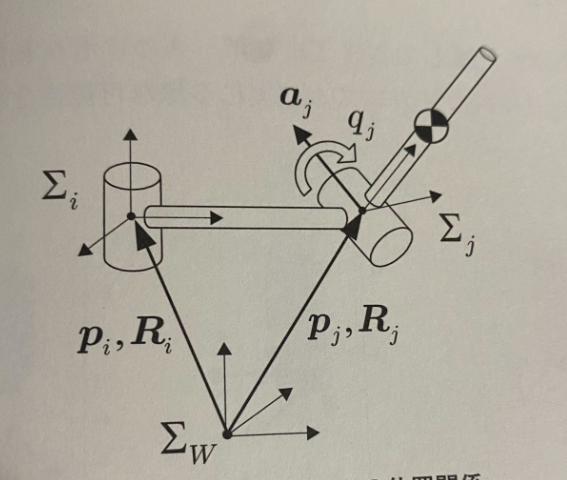

この関係式とPart1で説明した方法を用いれば、全リンクの位置と姿勢を計算するプログラムは次のPythonコードのように簡潔なものになる。\
予めボディリンクの絶対位置uLINK(1).p、絶対姿勢uLINK(1).Rおよび各リンクの関節回転角度qを設定しておき、ForwardKinematics(1)を実行することで自動的に全リンクの位置と姿勢が更新される。

In [3]:
# 順運動学の関数
def forward_kinematics(j):
    global uLINK

    if j == 0:
        return
    if j != 1:
        mom = uLINK[j].mother
        uLINK[j].p = uLINK[mom].R @ uLINK[j].b + uLINK[mom].p
        uLINK[j].R = uLINK[mom].R @ rodrigues(uLINK[j].a, uLINK[j].q)
    forward_kinematics(uLINK[j].sister)
    forward_kinematics(uLINK[j].child)

## リンクの位置と姿勢から関節角度を求める：逆運動学
次に与えられた胴体と足部の位置・座標から各関節の角度を求める方法について考える。このような場合に必要になるのが**逆運動学**である。\
例えば視覚センサで階段の高さの情報がわかっていたとして、正しい位置と高さに足を着地させるためには逆運動学が必須である。\
逆運動学は解析的に解く方法と数値的に解く方法の2種類がある。はじめに解析的に解く方法について説明する。\
先ほどのモデルの右足についてだけ考え、胴体と右足の位置姿勢がそれぞれ($p_1$, $R_1$), ($p_7$, $R_7$)として与えられたとする。式を見やすくするため

## 参考
(1)同次変換行列\
-Qiita記事\
https://qiita.com/akinami/items/9e65389929cedb1c9551

-研究室CPS_Lecture\
https://github.com/IRSL-tut/CPS-lecture/blob/main/notebooks/cps_lecture_coords00.ipynb

(2)チェーンルール\
同次変換行列どうしの掛け算の際に以下のようになる性質のこと
$$
^0T_1^1T_2...^{N-1}T_{N} = ^0T_N
$$
(3)ウェッジ\
以下記事でひずみ変換行列について書かれているのでそこを読むとよい。\
https://note.com/ss_sports_lab/n/na80cd8198d22